# Paradigm Free Mapping vs Total Activation: a comparison of the two methods

## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from pywt import wavedec
from scipy.signal import find_peaks
from scipy.stats import median_absolute_deviation
from sklearn.linear_model import lars_path

from Scripts.debiasing import debiasing_int as debiasing
from Scripts.fista_update import fista_update as fista
from Scripts.hrf_matrix import HRFMatrix
from Scripts.temporal_ta import filter_boundary as ta_filter
from Scripts.total_activation import total_activation as ta
from Scripts.total_activation import hrf_filters
from Scripts.simulate import fMRIsim

In [2]:
# Initialize class
sim = fMRIsim()

# Set parameters
sim.nvoxels = 1
sim.nevents = 3
sim.min_length = 1 # Minimun TR length of an event
sim.max_length = 5 # Maximum TR length of an event
sim.gap = 25 # Number of timepoints between events
sim.te = [35] # Must be a list
sim.db = 3

# Simulate timeseries
sim.simulate()


Groups: 1
Group change idxs: [0. 0.]
Voxel 1/1 simulated...
Saving simulated data...


## Load data

In [3]:
data = sim.simulation
ground_truth = sim.bold
nscans = data.shape[0]
nvoxels = data.shape[1]
print(f'Data has {nscans} scans and {nvoxels} voxels')

Data has 200 scans and 1 voxels


## Plot data

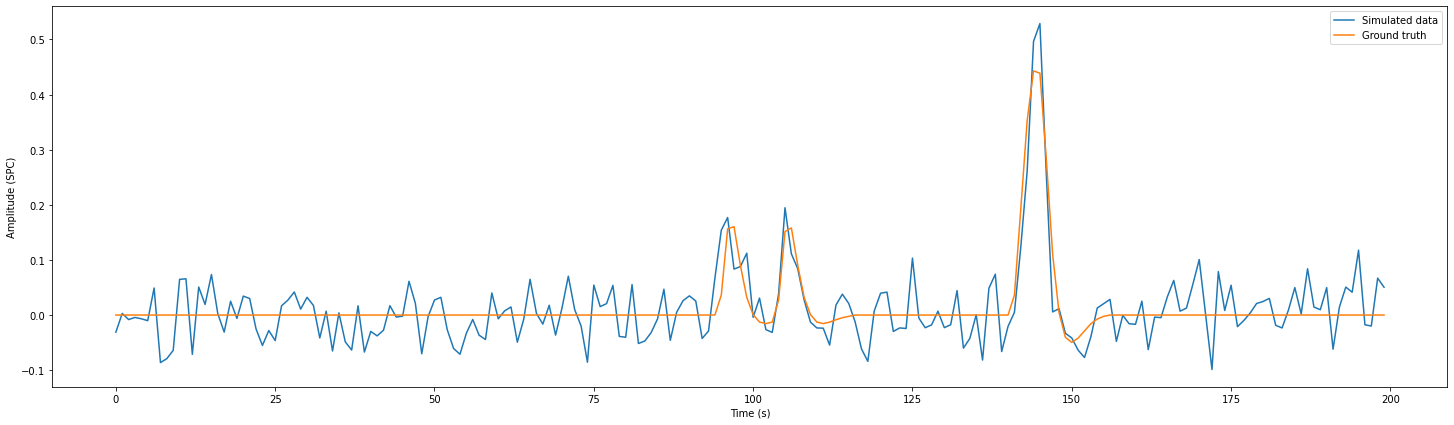

In [4]:
plt.figure(figsize=(25,7))
plt.plot(data[:, 0], label='Simulated data')
plt.plot(ground_truth, label='Ground truth')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (SPC)')
plt.legend()

## Data parameters

In [5]:
params = {'tr': 2, 'cost_save': True, 'te': [0]} # This is for TA (to follow MATLAB code structure)

/Users/enekourunuela/pfm_vs_ta/Scripts/total_activation.py:31: ComplexWarning: Casting complex values to real discards the imaginary part
  fil[i + 1] = (-1) ** (i + 1) * np.sum(np.exp(np.sum(combs_result, axis=1)))


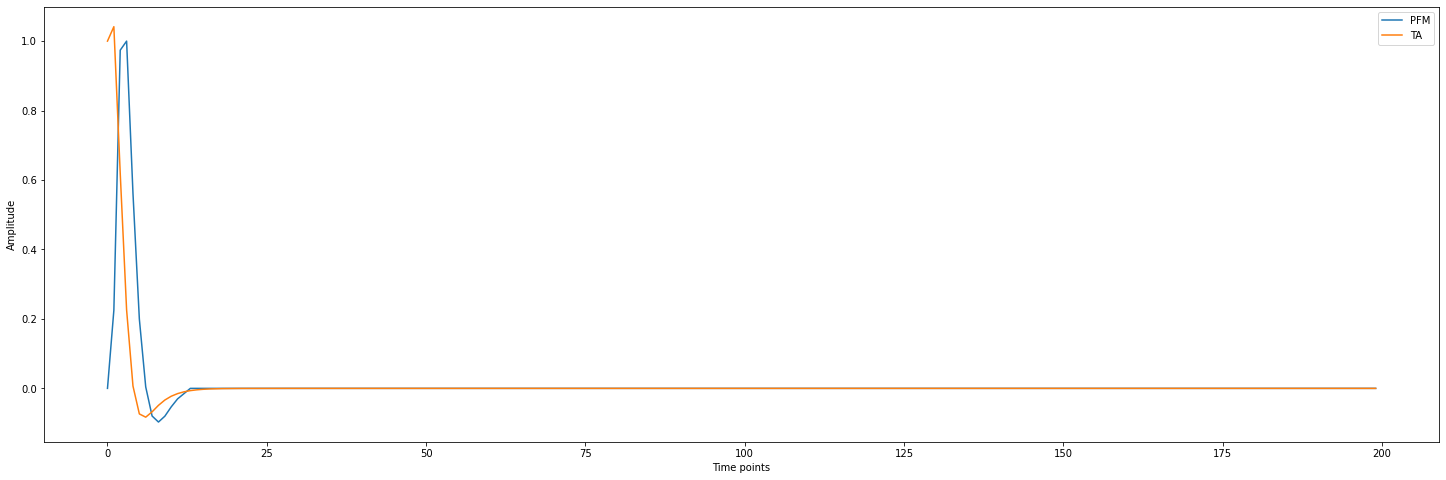

In [6]:
test_data = np.zeros(nscans)
test_data[int(0/params['tr'])] = 1

# Generate design matrix (shifted HRFs) for PFM with the spike model
hrf_matrix = HRFMatrix(TR=params['tr'], TE=params['te'], nscans=nscans, r2only=True, has_integrator=False, is_afni=True, lop_hrf='SPMG1')
hrf_matrix.generate_hrf()
hrf = hrf_matrix.X_hrf_norm

# Generate hrf filter for TA with spike model
params['model'] = 'spike'
params['f_analyze'], params['f_recons'], params['maxeig'] = hrf_filters(params['tr'], condition=params['model'], condition2='spmhrf')
n = params['f_recons']['den'][0]
d = [np.array(params['f_recons']['num']), 1]

bold_pfm = np.dot(hrf, test_data)
bold_ta = np.real(ta_filter(n, d, test_data.T, 'normal', nscans))

plt.figure(figsize=(25,8))
plt.plot(bold_pfm, label='PFM')
plt.plot(bold_ta, label='TA')
plt.xlabel('Time points')
plt.ylabel('Amplitude')
plt.legend()

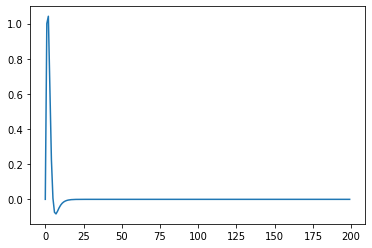

In [7]:
append_2 = 2*nscans - len(bold_ta)
temp = np.append(bold_ta, np.zeros(append_2))
for i in range(nscans-1):
    foo = np.append(np.zeros(i+1), bold_ta)
    append_2 = 2*nscans - len(foo)
    foo = np.append(foo, np.zeros(append_2))
    temp = np.column_stack((temp, foo))

hrf = temp[:nscans, :nscans]
plt.plot(hrf[:, 1])

## Runs spike model PFM and TA on every voxel

It runs LARS on PFM first, then uses the lambdas from LARS on TA.

In [8]:
# Generate hrf filter for TA with spike model
params['model'] = 'spike'
params['f_analyze'], params['f_recons'], params['maxeig'] = hrf_filters(params['tr'], condition=params['model'])
n = params['f_analyze']['num']
d = params['f_analyze']['den']

nlambdas = int(0.5*nscans)

for vox_idx in range(1): #range(nvoxels):
    print(f'Running LARS for PFM on voxel {vox_idx + 1} of {nvoxels}...')
    
    y = data[:, vox_idx]
    y = y[:, np.newaxis]
    
    pfm_max_lambda = np.max(np.dot(hrf.T, y))
    print(f'PFM max lambda: {pfm_max_lambda}')
    # LARS path
    lambdas_pfm_spike, _, pfm_spike_coef_path = lars_path(hrf, np.squeeze(y), method = 'lasso', Gram = np.dot(hrf.T, hrf),
                                                          Xy = np.dot(hrf.T, np.squeeze(y)), max_iter = nlambdas-1, eps=1e-9)
    
    lambdas_pfm_spike *= nscans
    pfm_spike_coef_path[abs(pfm_spike_coef_path) < 1e-3] = 0
    
    # Residuals
    L2res_pfm = np.sum((np.repeat(y, nlambdas, axis=-1) - np.dot(hrf, pfm_spike_coef_path))**2, axis=0)
    bic_pfm_spike = nscans*np.log(L2res_pfm) + np.log(nscans)*np.count_nonzero(pfm_spike_coef_path, axis=0)
    aic_pfm_spike = nscans*np.log(L2res_pfm) + 2*np.count_nonzero(pfm_spike_coef_path, axis=0)
    
    # Calculates regularization path for TA
    print(f'Calculating regularization path for TA on voxel {vox_idx + 1} of {nvoxels}...')
    #ta_max_lambda = np.max(ta_filter(n, d, y, 'transpose', nscans))
    ta_max_lambda = abs(np.max(y)/np.min(ta_filter(n, d, y, 'transpose', nscans))*params['maxeig'])
    print(f'TA max lambda: {ta_max_lambda}')
    #lambdas_ta_spike = np.geomspace(ta_max_lambda, 0.1*ta_max_lambda, nlambdas)
    lambdas_ta_spike = lambdas_pfm_spike.copy()
    ta_spike_coef_path = np.zeros(pfm_spike_coef_path.shape) # Shape: nscans x nlambdas
    for lambda_idx in range(nlambdas):
        ta_coefs, _ = ta(y, params, lambd=lambdas_ta_spike[lambda_idx])
        ta_spike_coef_path[:, lambda_idx] = np.squeeze(ta_coefs)
        
    ta_spike_coef_path[abs(ta_spike_coef_path) < 1e-3] = 0
    
    # Residuals
    L2res_ta = np.sum((np.repeat(y, nlambdas, axis=-1) - np.dot(hrf, ta_spike_coef_path))**2, axis=0)
    bic_ta_spike = nscans*np.log(L2res_ta) + np.log(nscans)*np.count_nonzero(ta_spike_coef_path, axis=0)
    aic_ta_spike = nscans*np.log(L2res_ta) + 2*np.count_nonzero(ta_spike_coef_path, axis=0)
    
    print(f'Regularization path of voxel {vox_idx + 1} calculated')
    
bic_pfm_spike_idx = np.argmin(bic_pfm_spike)
aic_pfm_spike_idx = np.argmin(aic_pfm_spike)
bic_ta_spike_idx = np.argmin(bic_ta_spike)
aic_ta_spike_idx = np.argmin(aic_ta_spike)

/Users/enekourunuela/pfm_vs_ta/Scripts/total_activation.py:31: ComplexWarning: Casting complex values to real discards the imaginary part
  fil[i + 1] = (-1) ** (i + 1) * np.sum(np.exp(np.sum(combs_result, axis=1)))


Running LARS for PFM on voxel 1 of 1...
PFM max lambda: 1.2225769568496458
Calculating regularization path for TA on voxel 1 of 1...
TA max lambda: 22.783117953815548
Regularization path of voxel 1 calculated


## Plot comparison of spike model regularization path

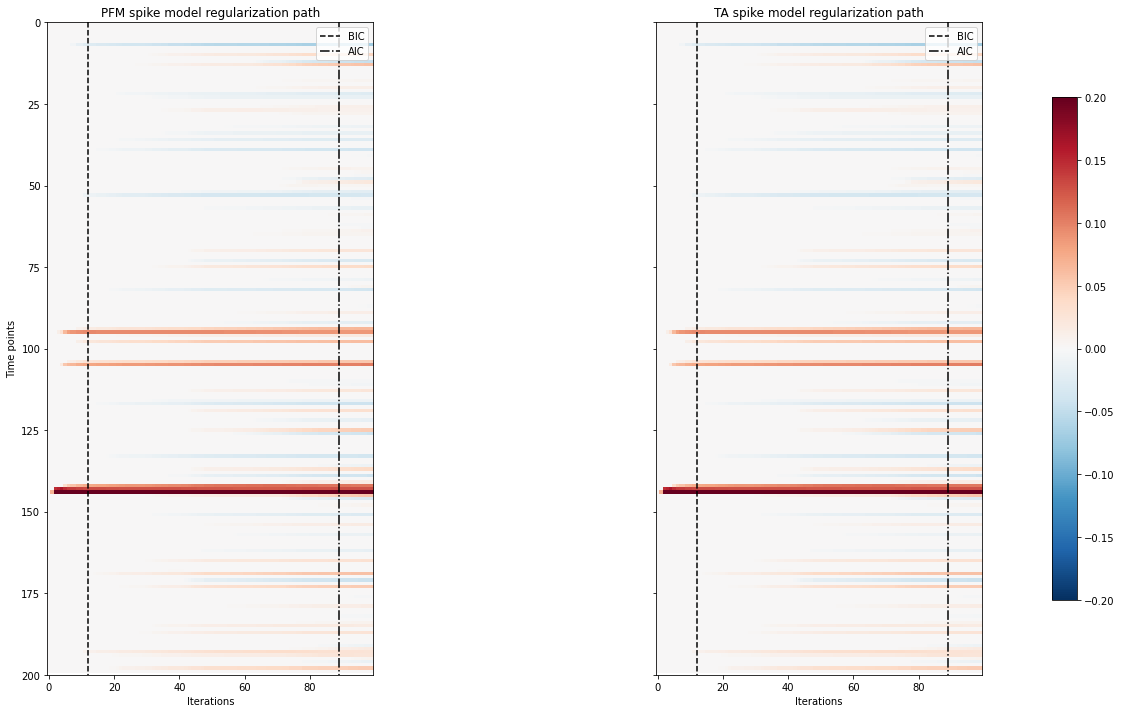

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(25,12))
im = ax1.imshow(pfm_spike_coef_path, cmap='RdBu_r', vmin=-.2, vmax=.2)
ax1.vlines(x=bic_pfm_spike_idx, ymin=0, ymax=nscans, color='black', linestyles='dashed', label='BIC')
ax1.vlines(x=aic_pfm_spike_idx, ymin=0, ymax=nscans, color='black', linestyles='dashdot', label='AIC')
ax1.set_ylim([nscans, 0])
ax1.legend()
ax1.set(xlabel='Iterations', ylabel='Time points')
ax1.set_title('PFM spike model regularization path')
ax2.imshow(ta_spike_coef_path, cmap='RdBu_r', vmin=-.2, vmax=.2)
ax2.vlines(x=bic_ta_spike_idx, ymin=0, ymax=nscans, color='black', linestyles='dashed', label='BIC')
ax2.vlines(x=aic_ta_spike_idx, ymin=0, ymax=nscans, color='black', linestyles='dashdot', label='AIC')
ax2.set_ylim([nscans, 0])
ax2.legend()
ax2.set(xlabel='Iterations')
ax2.set_title('TA spike model regularization path')
fig.colorbar(im, ax=[ax1, ax2], shrink=0.77)

Text(0.5, 1.0, 'TA spike model lambdas')

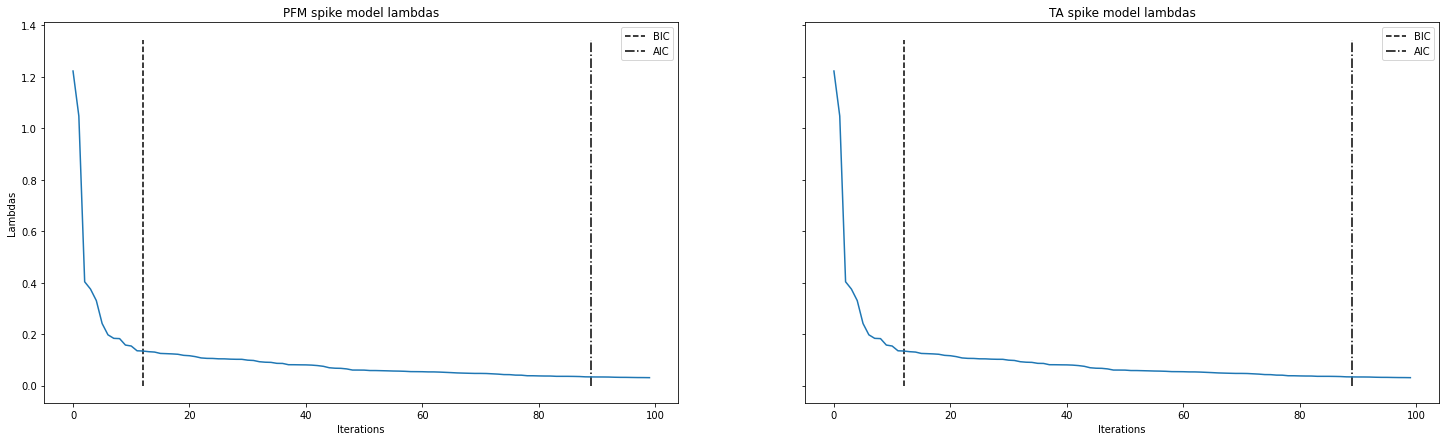

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(25,7))
ax1.plot(lambdas_pfm_spike)
ax1.vlines(x=bic_pfm_spike_idx, ymin=0, ymax=1.1*np.max(lambdas_pfm_spike), color='black', linestyles='dashed', label='BIC')
ax1.vlines(x=aic_pfm_spike_idx, ymin=0, ymax=1.1*np.max(lambdas_pfm_spike), color='black', linestyles='dashdot', label='AIC')
ax1.legend()
ax1.set(xlabel='Iterations', ylabel='Lambdas')
ax1.set_title('PFM spike model lambdas')
ax2.plot(lambdas_ta_spike)
ax2.vlines(x=bic_ta_spike_idx, ymin=0, ymax=1.1*np.max(lambdas_ta_spike), color='black', linestyles='dashed', label='BIC')
ax2.vlines(x=aic_ta_spike_idx, ymin=0, ymax=1.1*np.max(lambdas_ta_spike), color='black', linestyles='dashdot', label='AIC')
ax2.legend()
ax2.set(xlabel='Iterations')
ax2.set_title('TA spike model lambdas')

Text(0.5, 1.0, 'PFM vs TA: AIC with spikes')

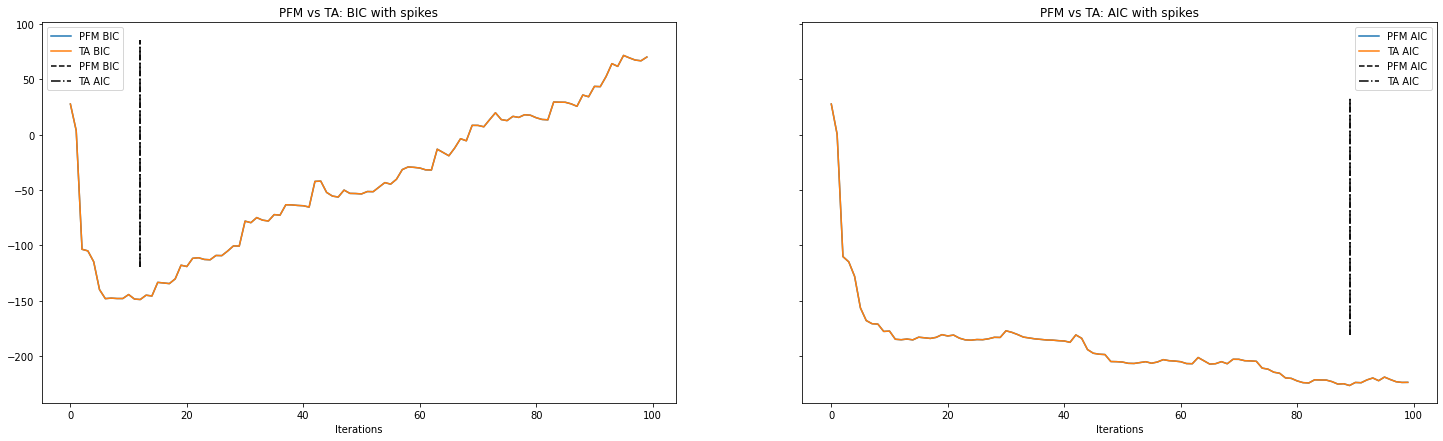

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(25,7))
ax1.plot(bic_pfm_spike, label='PFM BIC')
ax1.plot(bic_ta_spike, label='TA BIC')
ax1.vlines(x=bic_pfm_spike_idx, ymin=0.8*np.min(bic_pfm_spike), ymax=1.2*np.max(bic_pfm_spike), color='black', linestyles='dashed', label='PFM BIC')
ax1.vlines(x=bic_ta_spike_idx, ymin=0.8*np.min(bic_ta_spike), ymax=1.2*np.max(bic_ta_spike), color='black', linestyles='dashdot', label='TA AIC')
ax1.set(xlabel='Iterations')
ax1.set_title('PFM vs TA: BIC with spikes')
ax1.legend()
ax2.plot(aic_pfm_spike, label='PFM AIC')
ax2.plot(aic_ta_spike, label='TA AIC')
ax2.vlines(x=aic_pfm_spike_idx, ymin=0.8*np.min(aic_pfm_spike), ymax=1.2*np.max(aic_pfm_spike), color='black', linestyles='dashed', label='PFM AIC')
ax2.vlines(x=aic_ta_spike_idx, ymin=0.8*np.min(aic_ta_spike), ymax=1.2*np.max(aic_ta_spike), color='black', linestyles='dashdot', label='TA AIC')
ax2.set(xlabel='Iterations')
ax2.legend()
ax2.set_title('PFM vs TA: AIC with spikes')

## Runs block model PFM and TA on every voxel

In [12]:
# Generate hrf filter for TA with block model
params['model'] = 'block'
params['f_analyze'], params['f_recons'], params['maxeig'] = hrf_filters(params['tr'], condition=params['model'])
n = params['f_analyze']['num']
d = params['f_analyze']['den']

hrf_block = np.dot(hrf, np.tril(np.ones(nscans)))
nlambdas = int(0.5*nscans)

for vox_idx in range(1): #range(nvoxels):
    print(f'Running LARS for PFM on voxel {vox_idx + 1} of {nvoxels}...')
    
    y = data[:, vox_idx]
    y = y[:, np.newaxis]
    
    pfm_max_lambda = np.max(np.dot(hrf_block.T, y))
    print(f'PFM max lambda: {pfm_max_lambda}')
    # LARS path
    lambdas_pfm_block, _, pfm_block_coef_path = lars_path(hrf_block, np.squeeze(y), method = 'lasso', Gram = np.dot(hrf_block.T, hrf_block),
                                                          Xy = np.dot(hrf_block.T, np.squeeze(y)), max_iter = nlambdas-1, eps=1e-9)
    
    lambdas_pfm_block *= nscans
    pfm_block_coef_path[abs(pfm_block_coef_path) < 1e-3] = 0
    
    # Residuals
    L2res_pfm = np.sum((np.repeat(y, nlambdas, axis=-1) - np.dot(hrf_block, pfm_block_coef_path))**2, axis=0)
    bic_pfm_block = nscans*np.log(L2res_pfm) + np.log(nscans)*np.count_nonzero(pfm_block_coef_path, axis=0)
    aic_pfm_block = nscans*np.log(L2res_pfm) + 2*np.count_nonzero(pfm_block_coef_path, axis=0)
    
    # Calculates regularization path for TA
    print(f'Calculating regularization path for TA on voxel {vox_idx + 1} of {nvoxels}...')
    #ta_max_lambda = np.max(ta_filter(n, d, y, 'transpose', nscans))
    ta_max_lambda = abs(np.max(y)/np.min(ta_filter(n, d, y, 'transpose', nscans))*params['maxeig'])
    print(f'TA max lambda: {ta_max_lambda}')
#    lambdas_ta_block = np.geomspace(ta_max_lambda, 0.1*ta_max_lambda, nlambdas)
    lambdas_ta_block = lambdas_pfm_block.copy()
    ta_block_coef_path = np.zeros(pfm_block_coef_path.shape) # Shape: nscans x nlambdas
    for lambda_idx in range(nlambdas):
        ta_coefs, _ = ta(y, params, lambd=lambdas_ta_block[lambda_idx])
        ta_block_coef_path[:, lambda_idx] = np.squeeze(ta_coefs)
    
    ta_block_coef_path[abs(ta_block_coef_path) < 1e-3] = 0
    # Residuals
    L2res_ta = np.sum((np.repeat(y, nlambdas, axis=-1) - np.dot(hrf_block, ta_block_coef_path))**2, axis=0)
    bic_ta_block = nscans*np.log(L2res_ta) + np.log(nscans)*np.count_nonzero(ta_block_coef_path, axis=0)
    aic_ta_block = nscans*np.log(L2res_ta) + 2*np.count_nonzero(ta_block_coef_path, axis=0)
    
    print(f'Regularization path of voxel {vox_idx + 1} calculated')
    
    bic_pfm_block_idx = np.argmin(bic_pfm_block)
    aic_pfm_block_idx = np.argmin(aic_pfm_block)
    bic_ta_block_idx = np.argmin(bic_ta_block[10:]) + 10
    aic_ta_block_idx = np.argmin(aic_ta_block[10:]) + 10

/Users/enekourunuela/pfm_vs_ta/Scripts/total_activation.py:31: ComplexWarning: Casting complex values to real discards the imaginary part
  fil[i + 1] = (-1) ** (i + 1) * np.sum(np.exp(np.sum(combs_result, axis=1)))


Running LARS for PFM on voxel 1 of 1...
PFM max lambda: 7.654676059941427
Calculating regularization path for TA on voxel 1 of 1...
TA max lambda: 91.13225737187915
Regularization path of voxel 1 calculated


## Plot comparison of block model regularization path

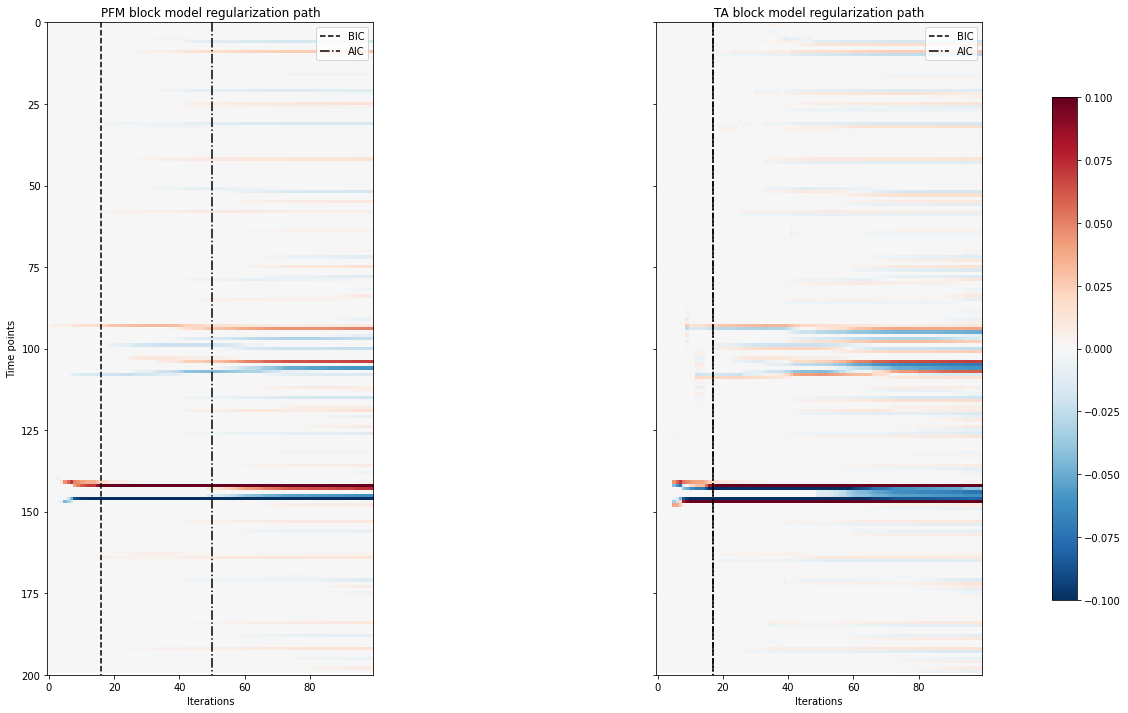

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(25,12))
im = ax1.imshow(pfm_block_coef_path, cmap='RdBu_r', vmin=-.1, vmax=.1)
ax1.vlines(x=bic_pfm_block_idx, ymin=0, ymax=nscans, color='black', linestyles='dashed', label='BIC')
ax1.vlines(x=aic_pfm_block_idx, ymin=0, ymax=nscans, color='black', linestyles='dashdot', label='AIC')
ax1.set_ylim([nscans, 0])
ax1.legend()
ax1.set(xlabel='Iterations', ylabel='Time points')
ax1.set_title('PFM block model regularization path')
ax2.imshow(ta_block_coef_path, cmap='RdBu_r', vmin=-.1, vmax=.1)
ax2.vlines(x=bic_ta_block_idx, ymin=0, ymax=nscans, color='black', linestyles='dashed', label='BIC')
ax2.vlines(x=aic_ta_block_idx, ymin=0, ymax=nscans, color='black', linestyles='dashdot', label='AIC')
ax2.set_ylim([nscans, 0])
ax2.legend()
ax2.set(xlabel='Iterations')
ax2.set_title('TA block model regularization path')
fig.colorbar(im, ax=[ax1, ax2], shrink=0.77)

Text(0.5, 1.0, 'TA block model lambdas')

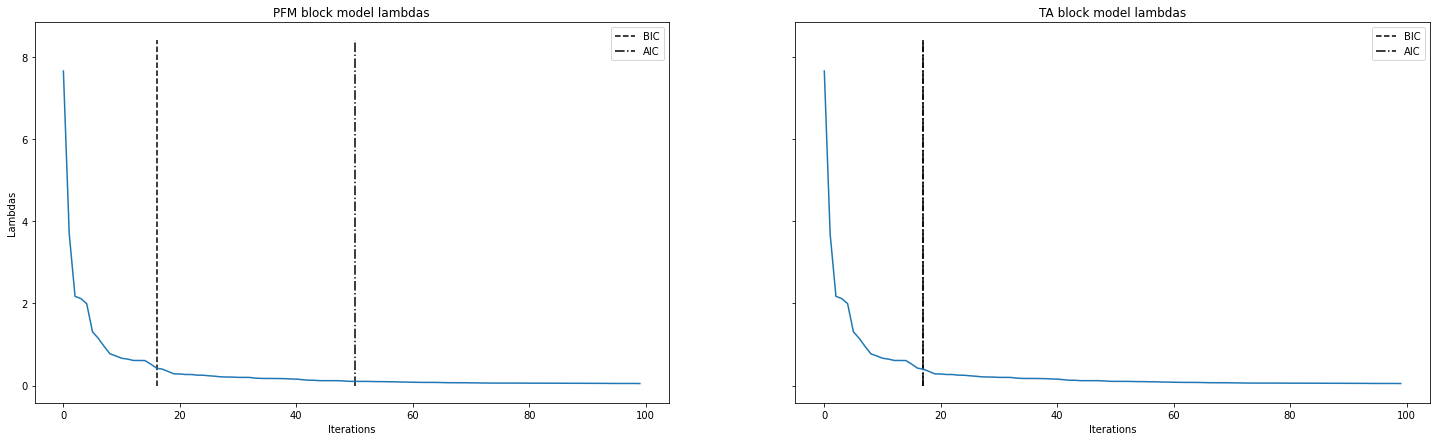

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(25,7))
ax1.plot(lambdas_pfm_block)
ax1.vlines(x=bic_pfm_block_idx, ymin=0, ymax=1.1*np.max(lambdas_pfm_block), color='black', linestyles='dashed', label='BIC')
ax1.vlines(x=aic_pfm_block_idx, ymin=0, ymax=1.1*np.max(lambdas_pfm_block), color='black', linestyles='dashdot', label='AIC')
ax1.legend()
ax1.set(xlabel='Iterations', ylabel='Lambdas')
ax1.set_title('PFM block model lambdas')
ax2.plot(lambdas_ta_block)
ax2.vlines(x=bic_ta_block_idx, ymin=0, ymax=1.1*np.max(lambdas_ta_block), color='black', linestyles='dashed', label='BIC')
ax2.vlines(x=aic_ta_block_idx, ymin=0, ymax=1.1*np.max(lambdas_ta_block), color='black', linestyles='dashdot', label='AIC')
ax2.legend()
ax2.set(xlabel='Iterations')
ax2.set_title('TA block model lambdas')

Text(0.5, 1.0, 'PFM vs TA: AIC with blocks')

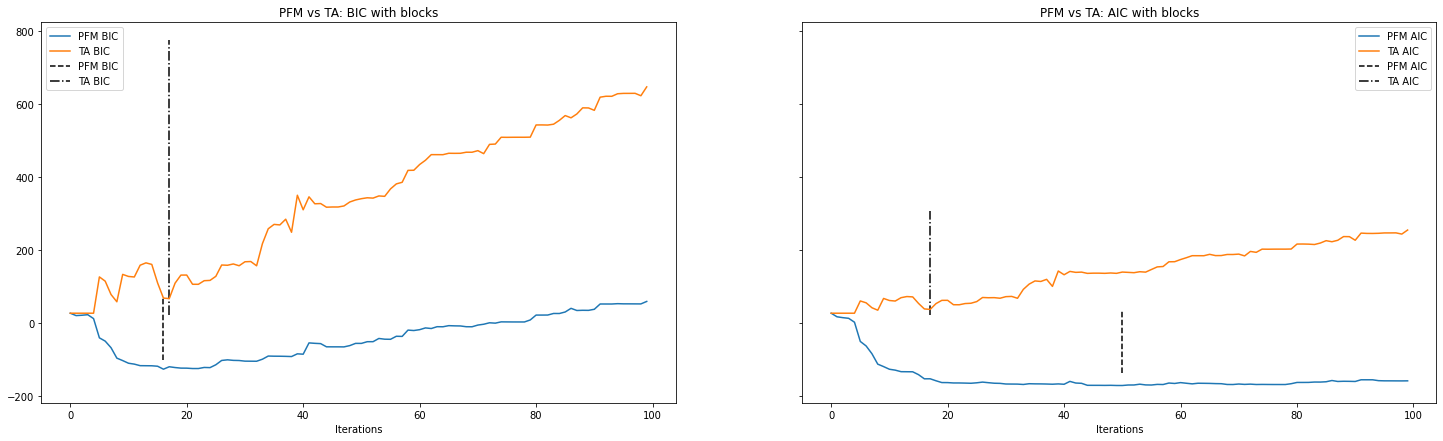

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(25,7))
ax1.plot(bic_pfm_block, label='PFM BIC')
ax1.plot(bic_ta_block, label='TA BIC')
ax1.vlines(x=bic_pfm_block_idx, ymin=0.8*np.min(bic_pfm_block), ymax=1.2*np.max(bic_pfm_block), color='black', linestyles='dashed', label='PFM BIC')
ax1.vlines(x=bic_ta_block_idx, ymin=0.8*np.min(bic_ta_block), ymax=1.2*np.max(bic_ta_block), color='black', linestyles='dashdot', label='TA BIC')
ax1.set(xlabel='Iterations')
ax1.set_title('PFM vs TA: BIC with blocks')
ax1.legend()
ax2.plot(aic_pfm_block, label='PFM AIC')
ax2.plot(aic_ta_block, label='TA AIC')
ax2.vlines(x=aic_pfm_block_idx, ymin=0.8*np.min(aic_pfm_block), ymax=1.2*np.max(aic_pfm_block), color='black', linestyles='dashed', label='PFM AIC')
ax2.vlines(x=aic_ta_block_idx, ymin=0.8*np.min(aic_ta_block), ymax=1.2*np.max(aic_ta_block), color='black', linestyles='dashdot', label='TA AIC')
ax2.set(xlabel='Iterations')
ax2.legend()
ax2.set_title('PFM vs TA: AIC with blocks')

## PFM vs TA with noise estimate and updating lambda (spike model)

In [16]:
# Generate hrf filter for TA with block model
params['model'] = 'spike'
params['f_analyze'], params['f_recons'], params['maxeig'] = hrf_filters(params['tr'], condition=params['model'])
n = params['f_analyze']['num']
d = params['f_analyze']['den']

nlambdas = nscans

for vox_idx in range(1):
    y = data[:, vox_idx]
    y = y[:, np.newaxis]
    
    _, cD1 = wavedec(y, 'db3', level=1, axis=0)
    noise_estimate = np.median(abs(cD1 - np.median(cD1))) / 0.8095
    
    pfm_spikes, _, _ = fista(hrf, y, max_iter=30, lambd=noise_estimate, update_lambda=True)
    ta_spikes, _ = ta(y, params, lambd=noise_estimate, update_lambda=True)

/Users/enekourunuela/pfm_vs_ta/Scripts/total_activation.py:31: ComplexWarning: Casting complex values to real discards the imaginary part
  fil[i + 1] = (-1) ** (i + 1) * np.sum(np.exp(np.sum(combs_result, axis=1)))


Text(0.5, 1.0, 'TA spike model with noise estimation')

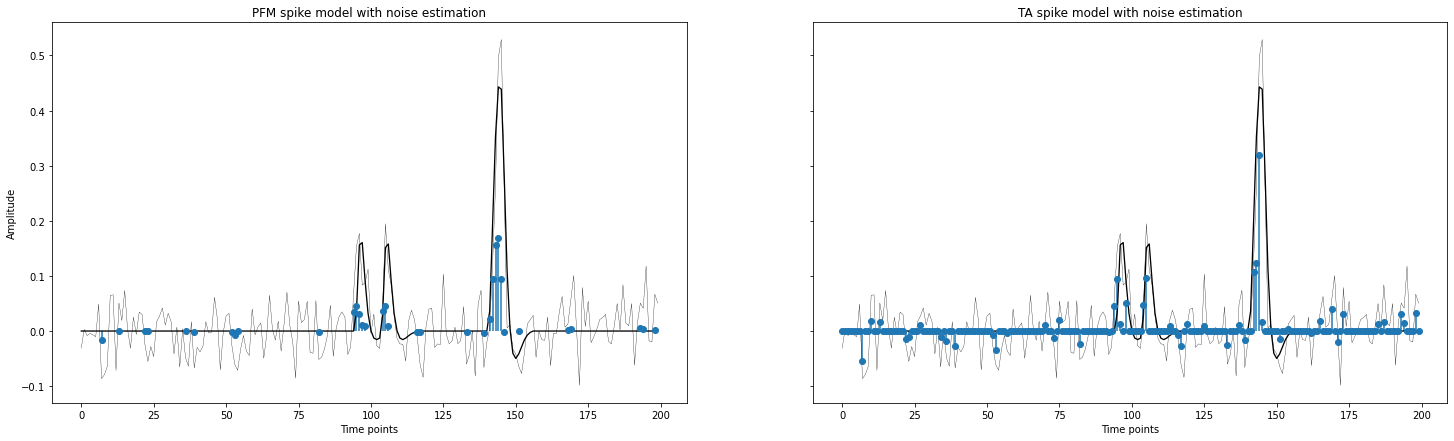

In [17]:
pfm_spikes_plot = pfm_spikes.copy()
pfm_spikes_plot[pfm_spikes_plot == 0] = np.nan
ta_spikes_plot = ta_spikes.copy()
ta_spikes_plot[ta_spikes_plot == 0] = np.nan

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(25,7))
ax1.plot(y, color='black', linewidth=.3, label='Simulation')
ax1.plot(ground_truth, color='black', linewidth='1.3', label='Ground truth')
ax1.stem(pfm_spikes_plot, label='PFM', use_line_collection=True, basefmt=" ")
ax1.set(xlabel='Time points', ylabel='Amplitude')
ax1.set_title('PFM spike model with noise estimation')
ax2.plot(y, color='black', linewidth=.3, label='Simulation')
ax2.plot(ground_truth, color='black', linewidth='1.3', label='Ground truth')
ax2.stem(ta_spikes_plot, label='TA', use_line_collection=True, basefmt=" ")
ax2.set(xlabel='Time points')
ax2.set_title('TA spike model with noise estimation')

## PFM vs TA with noise estimate and updating lambda (block model)

In [18]:
# Generate hrf filter for TA with block model
params['model'] = 'block'
params['f_analyze'], params['f_recons'], params['maxeig'] = hrf_filters(params['tr'], condition=params['model'])
n = params['f_analyze']['num']
d = params['f_analyze']['den']

nlambdas = nscans

for vox_idx in range(1):
    y = data[:, vox_idx]
    y = y[:, np.newaxis]
    
    _, cD1 = wavedec(y, 'db3', level=1, axis=0)
    noise_estimate = np.median(abs(cD1 - np.median(cD1))) / 0.8095
    
    pfm_block, _, _ = fista(hrf_block, y, max_iter=100, lambd=noise_estimate, update_lambda=True, precision=1e-3)
    ta_block, _ = ta(y, params, lambd=noise_estimate, update_lambda=True)

# Only keep peaks
pfm_block = np.squeeze(pfm_block)
peak_idxs, _ = find_peaks(abs(pfm_block), prominence=np.max(pfm_block)*0.01, distance=5)
temp = np.zeros((pfm_block.shape[0],))
temp[peak_idxs] = pfm_block[peak_idxs].copy()

ta_block = np.squeeze(ta_block)
ta_peak_idxs, _ = find_peaks(abs(ta_block), prominence=np.max(ta_block)*0.01, distance=5)
ta_temp = np.zeros((ta_block.shape[0],))
ta_temp[ta_peak_idxs] = ta_block[ta_peak_idxs].copy()

/Users/enekourunuela/pfm_vs_ta/Scripts/total_activation.py:31: ComplexWarning: Casting complex values to real discards the imaginary part
  fil[i + 1] = (-1) ** (i + 1) * np.sum(np.exp(np.sum(combs_result, axis=1)))


Text(0.5, 1.0, 'TA block model with noise estimation')

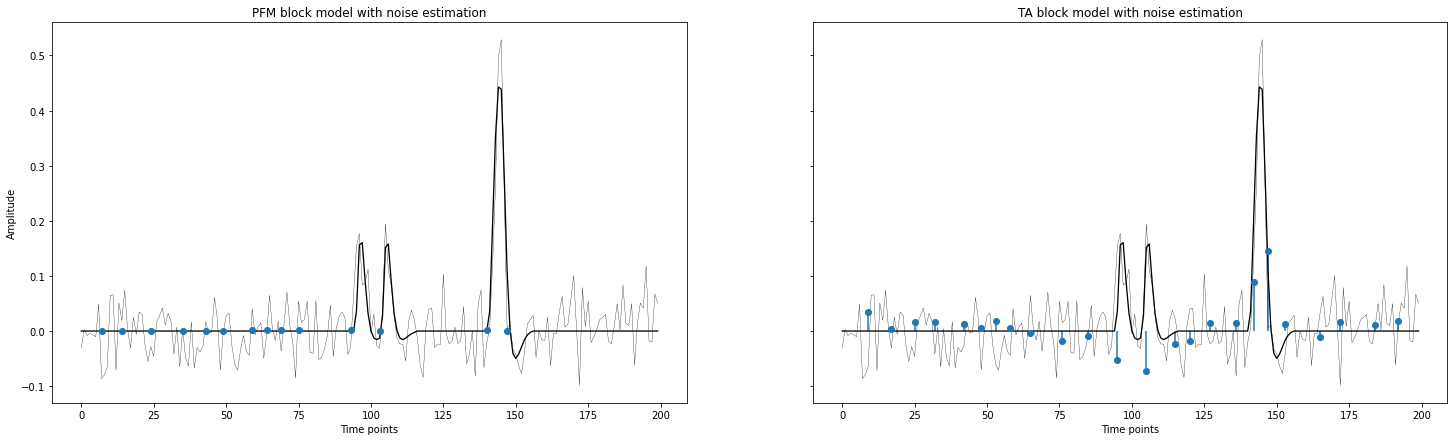

In [19]:
pfm_block_plot = temp.copy()
pfm_block_plot[pfm_block_plot == 0] = np.nan
ta_block_plot = ta_temp.copy()
ta_block_plot[ta_block_plot == 0] = np.nan
pfm_block_plot *= 10
#ta_block_plot *= 5

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(25,7))
ax1.plot(y, color='black', linewidth=.3, label='Simulation')
ax1.plot(ground_truth, color='black', linewidth='1.3', label='Ground truth')
ax1.stem(pfm_block_plot, label='PFM', use_line_collection=True, basefmt=" ")
#ax1.plot(10*temp, linewidth=2, label='PFM', color='#FF7E02')
ax1.set(xlabel='Time points', ylabel='Amplitude')
ax1.set_title('PFM block model with noise estimation')
ax2.plot(y, color='black', linewidth=.3, label='Simulation')
ax2.plot(ground_truth, color='black', linewidth='1.3', label='Ground truth')
ax2.stem(ta_block_plot, label='PFM', use_line_collection=True, basefmt=" ")
#ax2.plot(ta_block_plot, linewidth=2, label='TA', color='#FF7E02')
ax2.set(xlabel='Time points')
ax2.set_title('TA block model with noise estimation')